In [1]:
import sys

sys.path.append('./SimCLR')

In [2]:
import numpy as np
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

from models.resnet_simclr import ResNetSimCLR
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14, 'font.family': 'Verdana'})

# 1. TSNE 

In [15]:
simclr_reprs = np.load('reprs/simclr_reprs.npy')
supervised_reprs = np.load('reprs/supervised_reprs.npy')
randy_reprs = np.load('reprs/randy_reprs.npy')
randy_aug_reprs = np.load('reprs/randy_aug_reprs.npy')

In [16]:
from torchvision import datasets, transforms

train_dataset = datasets.CIFAR10('datasets/cifar10', train=True, download=True)
labels = np.array(train_dataset.targets)

Files already downloaded and verified


In [17]:
simclr_reprs, _, simclr_labels, _ = train_test_split(simclr_reprs, labels, stratify=labels,
                                                     train_size=0.25, random_state=100)
supervised_reprs, _, supervised_labels, _ = train_test_split(supervised_reprs, labels, stratify=labels,
                                                             train_size=0.25, random_state=100)
randy_reprs, _, randy_labels, _ = train_test_split(randy_reprs, labels, stratify=labels,
                                                   train_size=0.25, random_state=100)
randy_aug_reprs, _, randy_aug_labels, _ = train_test_split(randy_aug_reprs, labels, stratify=labels,
                                                           train_size=0.25, random_state=100)

In [18]:
%%time
simclr_tsne = TSNE(n_components=2, random_state=201)
simclr_tsne_reprs = simclr_tsne.fit_transform(simclr_reprs)

CPU times: user 4min 23s, sys: 5.84 s, total: 4min 28s
Wall time: 1min 25s


In [19]:
%%time
supervised_tsne = TSNE(n_components=2, random_state=202)
supervised_tsne_reprs = supervised_tsne.fit_transform(supervised_reprs)

CPU times: user 4min 26s, sys: 6.07 s, total: 4min 32s
Wall time: 1min 22s


In [20]:
%%time
randy_tsne = TSNE(n_components=2, random_state=203)
randy_tsne_reprs = randy_tsne.fit_transform(randy_reprs)

CPU times: user 4min 16s, sys: 5.32 s, total: 4min 21s
Wall time: 1min 22s


In [21]:
%%time
randy_aug_tsne = TSNE(n_components=2, random_state=204)
randy_aug_tsne_reprs = randy_aug_tsne.fit_transform(randy_aug_reprs)

CPU times: user 4min 37s, sys: 5.14 s, total: 4min 42s
Wall time: 1min 27s


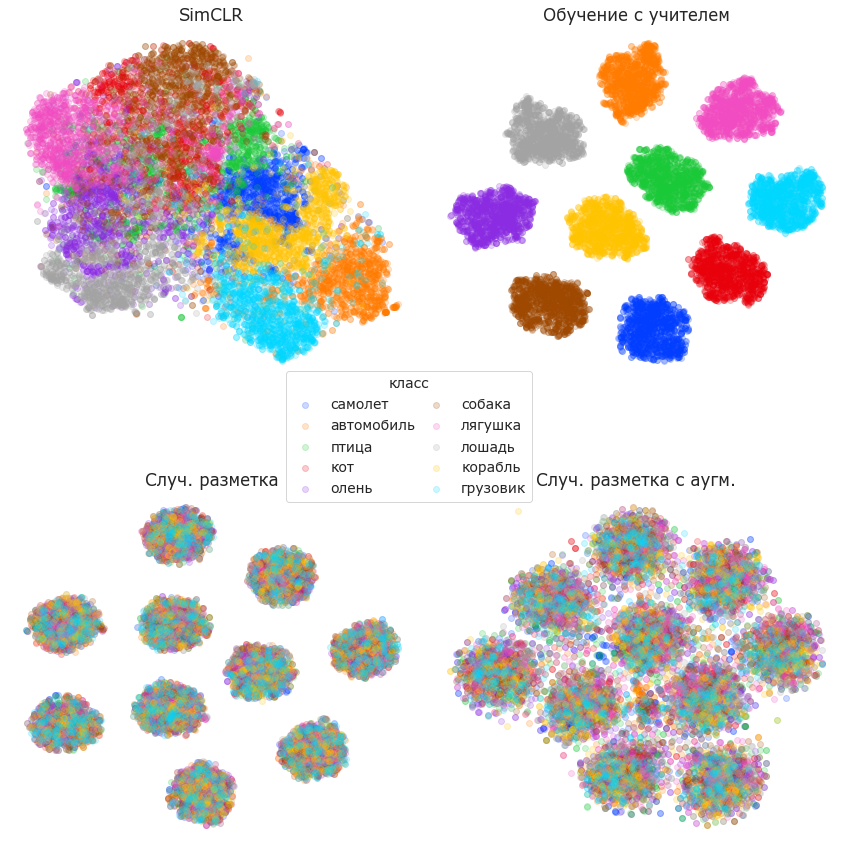

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
colors = sns.color_palette('bright', 10)
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

for i in range(10):
    axs[0, 0].scatter(simclr_tsne_reprs[simclr_labels == i, 0],
                   simclr_tsne_reprs[simclr_labels == i, 1],
                   color=colors[i], alpha=0.2, label=classes[i])
    axs[0, 1].scatter(supervised_tsne_reprs[supervised_labels == i, 0],
                   supervised_tsne_reprs[supervised_labels == i, 1],
                   color=colors[i], alpha=0.2, label=classes[i])
    axs[1, 0].scatter(randy_tsne_reprs[randy_labels == i, 0],
                   randy_tsne_reprs[randy_labels == i, 1],
                   color=colors[i], alpha=0.2, label=classes[i])
    axs[1, 1].scatter(randy_aug_tsne_reprs[randy_aug_labels == i, 0],
                   randy_aug_tsne_reprs[randy_aug_labels == i, 1],
                   color=colors[i], alpha=0.2, label=classes[i])

for ax in axs.flatten():
    ax.axis('off')

axs[0, 0].legend(bbox_to_anchor=(0.34, 0.41, 0.285, 0.6), loc='lower center', 
                 bbox_transform=fig.transFigure, ncol=2,
                 mode='expand', borderaxespad=0, title='класс')

axs[0, 0].set_title('SimCLR')
axs[0, 1].set_title('Обучение с учителем')
axs[1, 0].set_title('Случ. разметка')
axs[1, 1].set_title('Случ. разметка с аугм.')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('plots/tsne.pdf')
plt.show()

# 2. KL-divergence

In [6]:
import matplotlib.colors as colors

In [7]:
simclr_reprs = np.load('reprs/simclr_reprs.npy')
supervised_reprs = np.load('reprs/supervised_reprs.npy')

In [8]:
def fit_gaussian(x):
    mu = x.mean(axis=0)
    sigma = np.cov(x.T)
    return mu, sigma

In [9]:
def kl_divergence(mu1, mu2, sigma1, sigma2):
    _, logdet1 = np.linalg.slogdet(sigma1)
    _, logdet2 = np.linalg.slogdet(sigma2)
    
    sigma2_inv = np.linalg.inv(sigma2)
    tr = np.trace(sigma2_inv @ sigma1)
    d = mu1.shape[0]

    delta_mu = mu1 - mu2
    sq = delta_mu.reshape(1, d) @ sigma2_inv @ delta_mu.reshape(d, 1)
    sq = sq[0, 0]

    kl = 0.5 * (logdet2 - logdet1 - d + tr + sq)
    return kl

In [10]:
simclr_mus, simclr_sigmas = [], []
supervised_mus, supervised_sigmas = [], []

for i in range(10):
    mu, sigma = fit_gaussian(simclr_reprs[labels == i])
    simclr_mus += [mu]
    simclr_sigmas += [sigma]
    
    mu, sigma = fit_gaussian(supervised_reprs[labels == i])
    supervised_mus += [mu]
    supervised_sigmas += [sigma]

In [11]:
simclr_kl = np.zeros((10, 10))
supervised_kl = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        simclr_kl[i, j] = kl_divergence(simclr_mus[i], simclr_mus[j],
                                        simclr_sigmas[i], simclr_sigmas[j])
        supervised_kl[i, j] = kl_divergence(supervised_mus[i], supervised_mus[j],
                                            supervised_sigmas[i], supervised_sigmas[j])

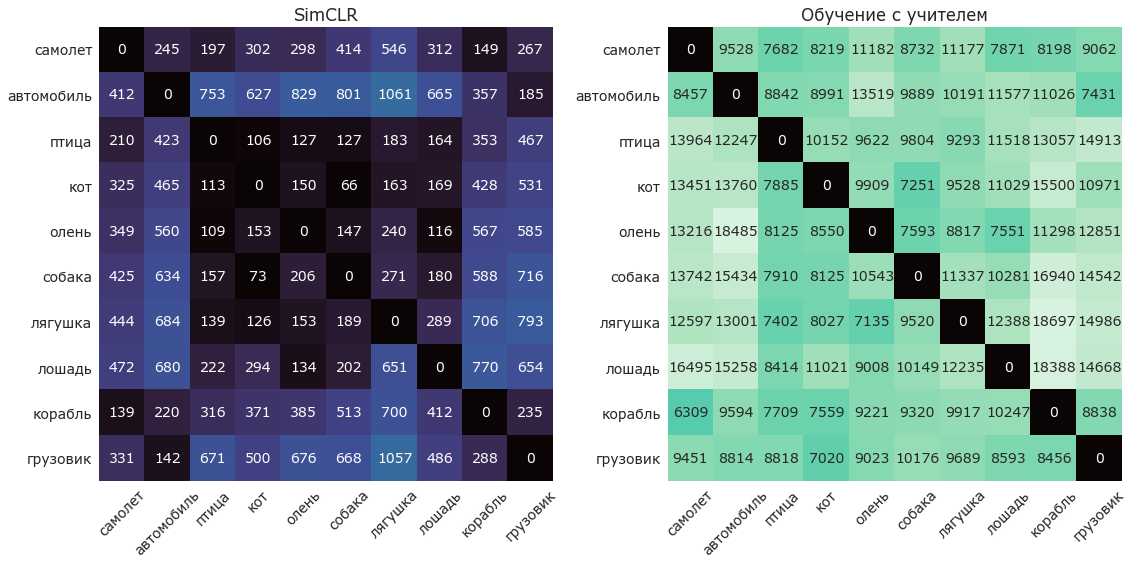

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

sns.heatmap(simclr_kl + 1e-10, ax=axs[0], annot=True, fmt='.0f',
            cbar=False, square=True, cmap='mako', yticklabels=classes,
            norm=colors.LogNorm(vmin=100, vmax=20000))
sns.heatmap(supervised_kl + 1e-10, ax=axs[1], annot=True, fmt='.0f',
            cbar=False, square=True, cmap='mako', yticklabels=classes,
            norm=colors.LogNorm(vmin=100, vmax=20000))

axs[0].set_title('SimCLR')
axs[1].set_title('Обучение с учителем')

axs[0].set_xticklabels(classes, rotation=45)
axs[1].set_xticklabels(classes, rotation=45)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.tight_layout()
plt.savefig('plots/kl_divergence.pdf')
plt.show()